## Classification of User Online Activity based on User Search History


#### Abstract
In this project we will try to classify the user browsing activity using machine learning techniques on the user’s clickstream data. Our data consists of text and multiple labels like Online Shopping, Net banking, Travel, etc. Firstly, we will use Natural Language Processing Techniques to preprocess the text data and then try supervised learning techniques to classify the user activity of Online Shopping. We will use multiple methods like decision tree, random forest, SVM, and MLP on the text data which will be processed to bag of words, TfIdf matrices, and Trigram matrices, then we will use evaluation methods like accuracy and confusion matrix to evaluate the results. We will also approach the problem through unsupervised learning techniques ie, clustering techniques to find out how the machine learning algorithm forms clusters on the text data. In the end, we will try to find out the intent of the search carried out by the user through web crawling techniques.

In [1]:
#As usual, in the first step we will import the libraries which we are gonna use.
import pandas as pd #pandas will help us reading the csv data to dataframes(df) and then working on the df.
import matplotlib.pyplot as plt #matplotlib will be used to visualize the data in the form of graphs.
import numpy as np # linear algebra
import string #for text pre-processing
import re #Regular expression operations
from sklearn.model_selection import KFold #for cross validations(CV)
from sklearn import metrics #for getting CV score
from collections import Counter #counting of words in the texts
import operator


In [2]:
import nltk
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
from nltk.corpus import stopwords #for removing stopwords
from nltk import ngrams
from nltk import word_tokenize

In [4]:
data = pd.read_excel(r'C:\Users\banerjee\Desktop\Dissertation\sensedataset.xlsx')

In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.shape

(1178, 10)

In [7]:
data.head()

,label,id,text,url,type,time,seen,label1,label2,label3
0,shopping,1529005370661,iphone x plus,https://www.google.co.in/search?q=iphone+x+plu...,search,2018-06-14T19:42:50.661Z,True,NaN,NaN,NaN
1,shopping,1529005417834,iphone x plus amazon,https://www.google.co.in/search?ei=O8UiW92GHZP...,search,2018-06-14T19:43:37.834Z,True,NaN,NaN,NaN
2,shopping,1529005428970,"Apple iPhone X (Space Grey, 256GB): Amazon.in:...",https://www.amazon.in/Apple-iPhone-Space-Grey-...,link,2018-06-14T19:43:48.970Z,True,NaN,NaN,NaN
3,shopping,1529005457957,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ...",https://www.amazon.in/Apple-iPhone-Plus-Gold-2...,link,2018-06-14T19:44:17.957Z,True,NaN,NaN,NaN
4,shopping,1529005482407,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele...",https://www.amazon.in/Apple-iPhone-X-Silver-25...,link,2018-06-14T19:44:42.407Z,True,NaN,NaN,NaN


In [8]:
group_by_label=data.groupby('label',as_index=False).count()

In [9]:
group_by_label

,label,id,text,url,type,time,seen,label1,label2,label3
0,hobbies,25,25,25,25,25,25,0,0,0
1,medical,45,45,45,45,45,45,0,0,0
2,netbanking,17,17,17,17,17,17,0,0,0
3,search for places,20,20,20,20,20,20,0,0,0
4,shopping,642,642,642,642,642,642,275,164,273
5,social network,67,67,67,67,67,67,0,0,0
6,study,109,109,109,109,109,109,0,0,0
7,travel,211,211,211,211,211,211,39,21,22
8,weather,42,42,37,42,42,42,0,0,0


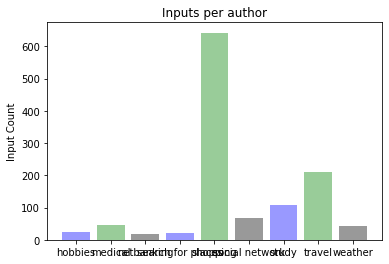

In [10]:
#Though it is clear that there is no much difference between the inputs for each classes(authors),
#we can still have a look at bar-chart for better visualisation.

objects = group_by_label['label']  #storing values of authors in objects
y_pos = np.arange(len(objects)) #creating numpy array for the count of authors
ids = group_by_label['id'] #assignig values of id for each author
 
plt.bar(y_pos, ids, align='center', alpha=0.4,color = 'bgk') #basic configuration for bar chart
plt.xticks(y_pos, objects) #assigning Labels to be displayed on X-axis
plt.ylabel('Input Count') #Labels for Y-axis
plt.title('Inputs per author') #Label for Chart
 
plt.show()

In [11]:
#Creating a backup of the dataset
data2_backup=pd.DataFrame(data)

In [12]:
#Label Encoding the data (label column) with shopping as 1 and others as 0
data['label'] = np.where(data['label']=='shopping', 1, 0)

In [13]:
group_by_label=data.groupby('label',as_index=False).count()
group_by_label

,label,id,text,url,type,time,seen,label1,label2,label3
0,0,536,536,531,536,536,536,39,21,22
1,1,642,642,642,642,642,642,275,164,273


In [14]:
#Selecting only the text column for further pre-processing
text=data.iloc[:,2:3]

In [15]:
text.head()

,text
0,iphone x plus
1,iphone x plus amazon
2,"Apple iPhone X (Space Grey, 256GB): Amazon.in:..."
3,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ..."
4,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele..."


In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
#Selecting a row of column'text' to test preprocessing steps
test_string_original=data.iloc[3,2]
test_string=data.iloc[3,2]

In [18]:
print(test_string)

Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: Electronics


In [19]:
#Function for removing punctuations from string
def remove_punctuations_from_string(string1):
    string1 = string1.lower() #changing to lower case
    translation_table = dict.fromkeys(map(ord, string.punctuation), ' ') #creating dictionary of punc & None
    string2 = string1.translate(translation_table) #translating string1
    return string2

test_string = remove_punctuations_from_string(test_string)
print('After removing punctuations:',test_string)

#Function for removing stopwords

def remove_stopwords_from_string(string1):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #compiling all stopwords.
    string2 = pattern.sub('', string1) #replacing the occurrences of stopwords in string1
    return string2

test_string = remove_stopwords_from_string(test_string)
print('After removing stopwords:',test_string)


def remove_space_from_string(string1):
    string1 = re.sub('\d+', '', string1) #stripping the numbers
    string2 = re.sub('\s{2,}', ' ', string1) #replacing the spaces
    string3 = re.sub('\n', '', string2) #stripping \n
    return string3

print('After removing space:',test_string,'\n')

print('Before processing:', test_string_original)

test_string = remove_space_from_string(test_string)
print('After processing:',test_string)

After removing punctuations: apple iphone 8 plus  gold  256gb   amazon in  electronics
After removing stopwords: apple iphone 8 plus  gold  256gb   amazon electronics
After removing space: apple iphone 8 plus  gold  256gb   amazon electronics 

Before processing: Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: Electronics
After processing: apple iphone plus gold gb amazon electronics


In [20]:
#Creating a new copy of the dataset with label, type and text columns
data3=pd.DataFrame(data['label'])
data3["type"] = data["type"].astype(str)
data3["text"] = data["text"].astype(str)
data3.head()

,label,type,text
0,1,search,iphone x plus
1,1,search,iphone x plus amazon
2,1,link,"Apple iPhone X (Space Grey, 256GB): Amazon.in:..."
3,1,link,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ..."
4,1,link,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele..."


In [21]:
#Applying above made functions on the 'text' column of the new copy of the dataset 'data3'.
data3["text_clean"] = data3["text"].apply(lambda x:remove_punctuations_from_string(x))
data3["text_remove_stopwords"] = data3["text_clean"].apply(lambda x:remove_stopwords_from_string(x))
data3["text_clean"] = data3["text_clean"].apply(lambda x:remove_space_from_string(x))
data3["text_remove_stopwords"] = data3["text_remove_stopwords"].apply(lambda x:remove_space_from_string(x))
data3.head()

,label,type,text,text_clean,text_remove_stopwords
0,1,search,iphone x plus,iphone x plus,iphone x plus
1,1,search,iphone x plus amazon,iphone x plus amazon,iphone x plus amazon
2,1,link,"Apple iPhone X (Space Grey, 256GB): Amazon.in:...",apple iphone x space grey gb amazon in electro...,apple iphone x space grey gb amazon electronics
3,1,link,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ...",apple iphone plus gold gb amazon in electronics,apple iphone plus gold gb amazon electronics
4,1,link,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele...",apple iphone x silver gb amazon in electronics,apple iphone x silver gb amazon electronics


In [22]:
#Lemmatize function

ps = nltk.PorterStemmer()

def text_stemmed(tokenized):
    string3 =[ps.stem(word) for word in tokenized]
    return string3


In [23]:
#Tokenize function

def tokenize(text):
    tokens = re.split('\W+',text)
    return tokens

data3["text_tokenized"] = data3["text_remove_stopwords"].apply(lambda x:tokenize(x))


#Lematize function data after tokenizing

wn = nltk.WordNetLemmatizer()
def lemmatize(tokenized_text):
    text2=[wn.lemmatize(word) for word in tokenized_text]
    return text2

data3["text_lemmatized"] = data3["text_tokenized"].apply(lambda x:lemmatize(x))


In [24]:
data3.head()

,label,type,text,text_clean,text_remove_stopwords,text_tokenized,text_lemmatized
0,1,search,iphone x plus,iphone x plus,iphone x plus,"[iphone, x, plus]","[iphone, x, plus]"
1,1,search,iphone x plus amazon,iphone x plus amazon,iphone x plus amazon,"[iphone, x, plus, amazon]","[iphone, x, plus, amazon]"
2,1,link,"Apple iPhone X (Space Grey, 256GB): Amazon.in:...",apple iphone x space grey gb amazon in electro...,apple iphone x space grey gb amazon electronics,"[apple, iphone, x, space, grey, gb, amazon, el...","[apple, iphone, x, space, grey, gb, amazon, el..."
3,1,link,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ...",apple iphone plus gold gb amazon in electronics,apple iphone plus gold gb amazon electronics,"[apple, iphone, plus, gold, gb, amazon, electr...","[apple, iphone, plus, gold, gb, amazon, electr..."
4,1,link,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele...",apple iphone x silver gb amazon in electronics,apple iphone x silver gb amazon electronics,"[apple, iphone, x, silver, gb, amazon, electro...","[apple, iphone, x, silver, gb, amazon, electro..."


In [25]:
#Remove empty rows after cleaning
# empty_rows=data3[data3['text_remove_stopwords'] == ''].index
# print(empty_rows)
# data3.head(80)

In [26]:
# data3=data3.drop(rr)
# data3.head(80)

In [27]:
#Train-Test Split
from sklearn.model_selection import train_test_split
train25, test25, train25_target, test25_target  = train_test_split(data3['text_remove_stopwords'],data3['label'], test_size=0.3)

In [28]:
print(train25.head(),'\n')
print(train25_target.head())

130                                                   rs 
26      buy dell inspiron i th gen gb tb dos int onlin...
1073                             fifa world cup wikipedia
442     tuition funding masters usc viterbi prospectiv...
227     art craft supplies buy art craft supplies onli...
Name: text_remove_stopwords, dtype: object 

130     1
26      1
1073    0
442     0
227     1
Name: label, dtype: int32


In [29]:
print(test25.head(),'\n')
print(test25_target.head())

351                                      courses program
550                        mykotakrewards flight booking
358                                                weeks
58     buy people black checked shirt women online in...
698                                 wilson brand rackets
Name: text_remove_stopwords, dtype: object 

351    0
550    0
358    0
58     1
698    1
Name: label, dtype: int32


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
train25_trans = vector.fit_transform(train25)
print(train25_trans.shape)
print (len(vector.get_feature_names()))
# print(vector.get_feature_names())
# print(vect.toarray())

(824, 1151)
1151


In [31]:
train25_trans

<824x1151 sparse matrix of type '<class 'numpy.int64'>'
	with 5084 stored elements in Compressed Sparse Row format>

In [32]:
test25_trans = vector.transform(test25)

In [33]:
test25_trans

<354x1151 sparse matrix of type '<class 'numpy.int64'>'
	with 1968 stored elements in Compressed Sparse Row format>

In [34]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(train25_trans,train25_target)

In [35]:
#Prediction on Test Data
dtree_pred=dtree.predict(test25_trans)

[Text(329.99138240574507, 216.6036923076923, 'X[30] <= 0.5\nentropy = 0.498\nsamples = 824\nvalue = [384, 440]'),
 Text(327.58707360861763, 214.93107692307692, 'X[125] <= 0.5\nentropy = 0.496\nsamples = 702\nvalue = [384, 318]'),
 Text(325.18276481149013, 213.25846153846155, 'X[375] <= 0.5\nentropy = 0.472\nsamples = 620\nvalue = [384, 236]'),
 Text(322.7784560143627, 211.58584615384615, 'X[970] <= 0.5\nentropy = 0.44\nsamples = 571\nvalue = [384, 187]'),
 Text(320.37414721723525, 209.91323076923078, 'X[538] <= 0.5\nentropy = 0.422\nsamples = 551\nvalue = [384, 167]'),
 Text(317.96983842010775, 208.24061538461538, 'X[637] <= 0.5\nentropy = 0.409\nsamples = 538\nvalue = [384, 154]'),
 Text(315.5655296229803, 206.56799999999998, 'X[628] <= 0.5\nentropy = 0.393\nsamples = 525\nvalue = [384, 141]'),
 Text(313.1612208258528, 204.89538461538461, 'X[207] <= 0.5\nentropy = 0.378\nsamples = 514\nvalue = [384, 130]'),
 Text(310.75691202872537, 203.22276923076922, 'X[549] <= 0.5\nentropy = 0.366\

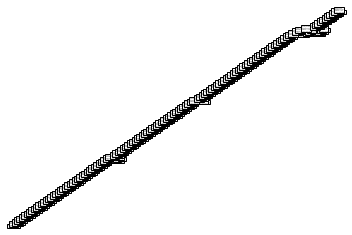

In [36]:
tree.plot_tree(dtree)
# dtree_pred

In [37]:
tree.export_graphviz(dtree)

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[30] <= 0.5\\ngini = 0.498\\nsamples = 824\\nvalue = [384, 440]"] ;\n1 [label="X[125] <= 0.5\\ngini = 0.496\\nsamples = 702\\nvalue = [384, 318]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[375] <= 0.5\\ngini = 0.472\\nsamples = 620\\nvalue = [384, 236]"] ;\n1 -> 2 ;\n3 [label="X[970] <= 0.5\\ngini = 0.44\\nsamples = 571\\nvalue = [384, 187]"] ;\n2 -> 3 ;\n4 [label="X[538] <= 0.5\\ngini = 0.422\\nsamples = 551\\nvalue = [384, 167]"] ;\n3 -> 4 ;\n5 [label="X[637] <= 0.5\\ngini = 0.409\\nsamples = 538\\nvalue = [384, 154]"] ;\n4 -> 5 ;\n6 [label="X[628] <= 0.5\\ngini = 0.393\\nsamples = 525\\nvalue = [384, 141]"] ;\n5 -> 6 ;\n7 [label="X[207] <= 0.5\\ngini = 0.378\\nsamples = 514\\nvalue = [384, 130]"] ;\n6 -> 7 ;\n8 [label="X[549] <= 0.5\\ngini = 0.366\\nsamples = 506\\nvalue = [384, 122]"] ;\n7 -> 8 ;\n9 [label="X[288] <= 0.5\\ngini = 0.353\\nsamples = 498\\nvalue = [384, 114]"] ;\n8 -> 9 ;\n10 [label="X

In [38]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [39]:
dtree_accuracy=accuracy_score(y_pred=dtree_pred, y_true=test25_target)
print('Accuracy: ',dtree_accuracy)
      
dtree_precision = precision_score(y_pred=dtree_pred, y_true=test25_target, average='weighted')
print('Precision:',dtree_precision)

dtree_recall = recall_score(y_pred=dtree_pred, y_true=test25_target, average='weighted')
print('Recall:',dtree_recall)

dtree_conf_matrix=confusion_matrix(y_pred=dtree_pred, y_true=test25_target)
print('\n Confusion Matrix:\n',dtree_conf_matrix)

target_names = ['class 0', 'class 1',]
print('\n Classification Report:\n',classification_report(y_pred=dtree_pred, y_true=test25_target, target_names=target_names))

Accuracy:  0.923728813559322
Precision: 0.9259736683521369
Recall: 0.923728813559322

 Confusion Matrix:
 [[131  21]
 [  6 196]]

 Classification Report:
               precision    recall  f1-score   support

     class 0       0.96      0.86      0.91       152
     class 1       0.90      0.97      0.94       202

    accuracy                           0.92       354
   macro avg       0.93      0.92      0.92       354
weighted avg       0.93      0.92      0.92       354



In [40]:
#Applying SVM Classification on Bag of Words data
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
bow_svm = SVM.fit(train25_trans,train25_target)
bow_svm_pred = SVM.predict(test25_trans)
# bow_svm_pred

bow_svm_accuracy=accuracy_score(y_pred=bow_svm_pred, y_true=test25_target)
print('Accuracy: ',bow_svm_accuracy)

bow_svm_precision = precision_score(y_pred=bow_svm_pred, y_true=test25_target, average='weighted')
print('Precision:',bow_svm_precision)

bow_svm_recall = recall_score(y_pred=bow_svm_pred, y_true=test25_target, average='weighted')
print('Recall:',bow_svm_recall)

bow_svm_conf_matrix=confusion_matrix(y_pred=bow_svm_pred, y_true=test25_target)
print('\n Confusion Matrix:\n',bow_svm_conf_matrix)

Accuracy:  0.9463276836158192
Precision: 0.9467394110908214
Recall: 0.9463276836158192

 Confusion Matrix:
 [[139  13]
 [  6 196]]


In [41]:
#Applying RF Classification on Bag of Words data
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)
bow_rf = RF.fit(train25_trans,train25_target)
bow_rf_pred = RF.predict(test25_trans)
# bow_rf_pred

bow_rf_accuracy=accuracy_score(y_pred=bow_rf_pred, y_true=test25_target)
print('Accuracy: ',bow_rf_accuracy)

bow_rf_precision = precision_score(y_pred=bow_rf_pred, y_true=test25_target, average='weighted')
print('Precision:',bow_rf_precision)

bow_rf_recall = recall_score(y_pred=bow_rf_pred, y_true=test25_target, average='weighted')
print('Recall:',bow_rf_recall)

bow_rf_conf_matrix=confusion_matrix(y_pred=bow_rf_pred, y_true=test25_target)
print('\n Confusion Matrix:\n',bow_rf_conf_matrix)

Accuracy:  0.9152542372881356
Precision: 0.9194764872730974
Recall: 0.9152542372881356

 Confusion Matrix:
 [[127  25]
 [  5 197]]


In [42]:
# #Applying AdaBoost Classification on Bag of Words data
# from sklearn.ensemble import AdaBoostClassifier

# ADA = AdaBoostClassifier(n_estimators=1000, random_state=0)
# bow_ada = ADA.fit(train25_trans,train25_target)
# bow_ada_pred = ADA.predict(test25_trans)
# # bow_ada_pred
# bow_ada_accuracy=accuracy_score(y_pred=bow_ada_pred, y_true=test25_target)
# print('Accuracy: ',bow_ada_accuracy)

# dtree_precision = precision_score(y_pred=bow_ada_pred, y_true=test25_target, average='weighted')
# print('Precision:',dtree_precision)

# dtree_recall = recall_score(y_pred=bow_ada_pred, y_true=test25_target, average='weighted')
# print('Recall:',dtree_recall)

# dtree_conf_matrix=confusion_matrix(y_pred=bow_ada_pred, y_true=test25_target)
# print('\n Confusion Matrix:\n',dtree_conf_matrix)

In [43]:
#Applying MLP on Bag of Words data
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1)
bow_mlp = MLP.fit(train25_trans,train25_target)
bow_mlp_pred = MLP.predict(test25_trans)

# bow_mlp_pred

bow_mlp_accuracy=accuracy_score(y_pred=bow_mlp_pred, y_true=test25_target)
print('Accuracy: ',bow_mlp_accuracy)

bow_mlp_precision = precision_score(y_pred=bow_mlp_pred, y_true=test25_target, average='weighted')
print('Precision:',dtree_precision)

bow_mlp_recall = recall_score(y_pred=bow_mlp_pred, y_true=test25_target, average='weighted')
print('Recall:',dtree_recall)

bow_mlp_conf_matrix=confusion_matrix(y_pred=bow_mlp_pred, y_true=test25_target)
print('\n Confusion Matrix:\n',bow_mlp_conf_matrix)

Accuracy:  0.940677966101695
Precision: 0.9259736683521369
Recall: 0.923728813559322

 Confusion Matrix:
 [[137  15]
 [  6 196]]


In [44]:
#Applying NB on Bag of Words data
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
bow_nb = NB.fit(train25_trans, train25_target)
bow_nb_pred = NB.predict(test25_trans)
#bow_nb_pred
bow_nb_accuracy=accuracy_score(y_pred=bow_nb_pred, y_true=test25_target)
print('Accuracy: ',bow_nb_accuracy)

Accuracy:  0.9463276836158192


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
#Creating vectors of tfidf data
vector2 = TfidfVectorizer()
train25_trans_tfidf = vector2.fit_transform(train25)
print(train25_trans_tfidf.shape)
print (len(vector2.get_feature_names()))
# print(vector2.get_feature_names())

(824, 1151)
1151


In [47]:
train25_trans_tfidf

<824x1151 sparse matrix of type '<class 'numpy.float64'>'
	with 5084 stored elements in Compressed Sparse Row format>

In [48]:
test25_trans_tfidf = vector2.transform(test25)

In [49]:
#Creating dtree of tfidf data
dtree = tree.DecisionTreeClassifier()
dtree_tfidf = dtree.fit(train25_trans_tfidf,train25_target)
dtree_pred_tfidf=dtree_tfidf.predict(test25_trans_tfidf)
# dtree_pred_tfidf

In [50]:
dtree_accuracy_tfidf=accuracy_score(y_pred=dtree_pred_tfidf, y_true=test25_target)
print('Accuracy_tfidf: ',dtree_accuracy_tfidf)

Accuracy_tfidf:  0.9350282485875706


In [51]:
#Applying SVM Classification on Tfidf data
from sklearn import svm
SVM = svm.SVC(C=0.8, kernel='linear', degree=3, gamma='auto')
tfidf_svm = SVM.fit(train25_trans_tfidf,train25_target)
tfidf_svm_pred = SVM.predict(test25_trans_tfidf)
# tfidf_svm_pred
tfidf_svm_accuracy=accuracy_score(y_pred=tfidf_svm_pred, y_true=test25_target)
print('Accuracy: ',tfidf_svm_accuracy)

Accuracy:  0.9265536723163842


In [52]:
#Applying RF Classification on tfidf data
# from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)
tfidf_rf = RF.fit(train25_trans_tfidf,train25_target)
tfidf_rf_pred = RF.predict(test25_trans_tfidf)
# rf_svm_pred
tfidf_rf_accuracy=accuracy_score(y_pred=tfidf_rf_pred, y_true=test25_target)
print('Accuracy: ',tfidf_rf_accuracy)

Accuracy:  0.9180790960451978


In [53]:
#Applying NB on tfidf data
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
tfidf_nb = NB.fit(train25_trans_tfidf, train25_target)
tfidf_nb_pred = NB.predict(test25_trans_tfidf)
#tfidf_nb_pred
tfidf_nb_accuracy=accuracy_score(y_pred=tfidf_nb_pred, y_true=test25_target)
print('Accuracy: ',tfidf_nb_accuracy)

Accuracy:  0.9519774011299436


In [54]:
#Creating vectors of trigram data
vector_trigram = CountVectorizer(ngram_range=(1,3))
train25_trans_trigram = vector_trigram.fit_transform(train25)
print(train25_trans_trigram.shape)
# print(vector_trigram.get_feature_names())

(824, 4752)


In [55]:
test25_trans_trigram = vector_trigram.transform(test25)

In [56]:
#Applying dtree on trigram data
dtree = tree.DecisionTreeClassifier()
dtree_trigram = dtree.fit(train25_trans_trigram,train25_target)
dtree_pred_trigram=dtree_trigram.predict(test25_trans_trigram)
# dtree_pred_trigram

In [57]:
dtree_accuracy_trigram = accuracy_score(y_pred=dtree_pred_trigram, y_true=test25_target)
print('Accuracy_trigram: ',dtree_accuracy_trigram)

Accuracy_trigram:  0.9180790960451978


In [58]:
#Applying SVM Classification on trigram data
from sklearn import svm
SVM = svm.SVC(C=0.3, kernel='linear', degree=3, gamma='auto')
trigram_svm = SVM.fit(train25_trans_trigram,train25_target)
trigram_svm_pred = SVM.predict(test25_trans_trigram)
# bow_svm_pred
trigram_svm_accuracy=accuracy_score(y_pred=trigram_svm_pred, y_true=test25_target)
print('Accuracy: ',trigram_svm_accuracy)

Accuracy:  0.9491525423728814


In [59]:
#Creating the dataframe for applying Clustering 
data4 = pd.read_excel(r'C:\Users\banerjee\Desktop\Dissertation\sensedataset.xlsx')
# data4.head()

In [60]:
# Categorizing the labels with numbers 
data4.loc[data4.label =='shopping', 'label'] = 1
data4.loc[data4.label =='hobbies', 'label'] = 2
data4.loc[data4.label =='medical', 'label'] = 3
data4.loc[data4.label =='netbanking', 'label'] = 4
data4.loc[data4.label =='search for places', 'label'] = 5
data4.loc[data4.label =='social network', 'label'] = 6
data4.loc[data4.label =='study', 'label'] = 7
data4.loc[data4.label =='travel', 'label'] = 8
data4.loc[data4.label =='weather', 'label'] = 9

In [61]:
#Visualising the labels with other columns
data4.groupby('label',as_index=False).count()


,label,id,text,url,type,time,seen,label1,label2,label3
0,1,642,642,642,642,642,642,275,164,273
1,2,25,25,25,25,25,25,0,0,0
2,3,45,45,45,45,45,45,0,0,0
3,4,17,17,17,17,17,17,0,0,0
4,5,20,20,20,20,20,20,0,0,0
5,6,67,67,67,67,67,67,0,0,0
6,7,109,109,109,109,109,109,0,0,0
7,8,211,211,211,211,211,211,39,21,22
8,9,42,42,37,42,42,42,0,0,0


In [62]:
#Applying above made functions on the 'text' column of the new copy of the dataset 'data3'.
data4["text"] = data4["text"].astype(str)
data4["text_clean"] = data4["text"].apply(lambda x:remove_punctuations_from_string(x))
data4["text_remove_stopwords"] = data4["text_clean"].apply(lambda x:remove_stopwords_from_string(x))
data4["text_clean"] = data4["text_clean"].apply(lambda x:remove_space_from_string(x))
data4["text_remove_stopwords"] = data4["text_remove_stopwords"].apply(lambda x:remove_space_from_string(x))
data4.head()

,label,id,text,url,type,time,seen,label1,label2,label3,text_clean,text_remove_stopwords
0,1,1529005370661,iphone x plus,https://www.google.co.in/search?q=iphone+x+plu...,search,2018-06-14T19:42:50.661Z,True,NaN,NaN,NaN,iphone x plus,iphone x plus
1,1,1529005417834,iphone x plus amazon,https://www.google.co.in/search?ei=O8UiW92GHZP...,search,2018-06-14T19:43:37.834Z,True,NaN,NaN,NaN,iphone x plus amazon,iphone x plus amazon
2,1,1529005428970,"Apple iPhone X (Space Grey, 256GB): Amazon.in:...",https://www.amazon.in/Apple-iPhone-Space-Grey-...,link,2018-06-14T19:43:48.970Z,True,NaN,NaN,NaN,apple iphone x space grey gb amazon in electro...,apple iphone x space grey gb amazon electronics
3,1,1529005457957,"Apple iPhone 8 Plus (Gold, 256GB): Amazon.in: ...",https://www.amazon.in/Apple-iPhone-Plus-Gold-2...,link,2018-06-14T19:44:17.957Z,True,NaN,NaN,NaN,apple iphone plus gold gb amazon in electronics,apple iphone plus gold gb amazon electronics
4,1,1529005482407,"Apple iPhone X (Silver, 256GB): Amazon.in: Ele...",https://www.amazon.in/Apple-iPhone-X-Silver-25...,link,2018-06-14T19:44:42.407Z,True,NaN,NaN,NaN,apple iphone x silver gb amazon in electronics,apple iphone x silver gb amazon electronics


In [63]:
#Clustering with KMeans

#Splitting the data to test and tarin
train52, test52, train52_target, test52_target = train_test_split(data4['text_remove_stopwords'],data4['label'], test_size=0.2)

#Creating vectors of tfidf data
vector5 = TfidfVectorizer()
train52_trans_tfidf = vector5.fit_transform(train25)
print(train52_trans_tfidf.shape)
print (len(vector5.get_feature_names()))
# print(vector2.get_feature_names())

train52_trans_tfidf


(824, 1151)
1151


<824x1151 sparse matrix of type '<class 'numpy.float64'>'
	with 5084 stored elements in Compressed Sparse Row format>

In [64]:
#Transforming the test data
test52_trans = vector.transform(test52)

In [65]:
#Fit KMeans model on the data
from sklearn.cluster import KMeans
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(train52_trans_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=9, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [66]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vector5.get_feature_names()

In [67]:
order_centroids
# terms

array([[1133,  901,  662, ...,  750,  749,    0],
       [ 477,  955, 1150, ...,  758,  757,    0],
       [1111,   81,  866, ...,  757,  756,    0],
       ...,
       [ 653,  482, 1072, ...,  752,  751,    0],
       [1121,  889,  791, ...,  755,  754,    0],
       [ 530,  660,  994, ...,  757,  756,    0]], dtype=int32)

In [68]:
#Check clusters created by the model

for i in range(true_k):
    print('Cluster ', i)
    for ind in order_centroids[i, :10]:
        print(terms[ind])

Cluster  0
women
shirts
myntra
shirt
buy
tops
roadster
tshirts
solid
sunglasses
Cluster  1
instagram
stories
zero
helpline
general
genius
georgia
getaway
git
github
Cluster  2
weather
bbc
saturday
london
hendon
chealsea
central
rickmansworth
glue
genius
Cluster  3
ladies
dress
gb
wrap
black
floral
jersey
spotted
patterned
pink
Cluster  4
cafes
london
zero
glue
genius
georgia
getaway
git
github
gloss
Cluster  5
online
amazon
buy
india
best
rs
google
sneakers
linkedin
dresses
Cluster  6
musical
instruments
usb
microphone
co
uk
blue
amazon
microphones
audio
Cluster  7
wiki
sensemaking
provenancelearning
vissense
set
data
zero
getaway
gen
general
Cluster  8
kr
mxl
tempo
condenser
musical
instruments
usb
microphone
co
uk


In [69]:
# Predicted output
predicted = model.predict(test52_trans)
print(predicted)

[6 5 5 0 5 6 5 5 5 4 3 5 6 5 7 5 0 3 5 5 5 5 0 6 5 5 7 5 5 5 6 5 4 5 2 5 3
 0 3 4 5 5 5 5 5 5 5 0 6 5 0 6 5 5 5 5 7 4 1 5 5 7 5 5 5 5 5 5 5 5 6 5 5 5
 5 4 5 3 5 5 6 5 5 5 4 6 5 5 5 3 2 0 5 5 5 5 5 5 5 5 6 4 3 5 4 3 5 3 5 5 6
 5 5 5 5 0 5 5 5 6 5 6 7 5 5 3 5 5 5 5 0 6 6 5 3 5 6 3 5 0 5 5 5 5 5 5 2 5
 5 0 6 5 5 5 4 5 5 5 1 5 6 5 5 5 5 5 5 5 3 0 5 5 5 5 5 5 6 5 4 4 6 5 5 5 6
 0 5 2 5 4 5 5 5 0 5 3 5 5 0 5 6 4 5 2 5 5 6 5 3 5 5 5 6 2 5 5 4 5 5 5 6 5
 5 5 5 6 1 5 6 3 5 5 5 4 0 5]


In [70]:
# Evaluate Clustering with actual test target data
metrics.adjusted_rand_score(test52_target, predicted)  


-0.029350276461928244

<class 'bs4.BeautifulSoup'>


<!DOCTYPE html>
<html lang="en">
<head>
<link href="https://rukminim1.flixcart.com" rel="dns-prefetch"/>
<link href="https://img1a.flixcart.com" rel="dns-prefetch"/>
<link href="//img1a.flixcart.com/www/linchpin/fk-cp-zion/css/app.chunk.b75b00.css" rel="stylesheet"/>
<link as="image" href="//img1a.flixcart.com/www/linchpin/fk-cp-zion/img/fk-logo_9fddff.png" rel="preload"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="102988293558" property="fb:page_id"/>
<meta content="658873552,624500995,100000233612389" property="fb:admins"/>
<meta content="noodp" name="robots"/>
<link href="https://img1a.flixcart.com/www/promos/new/20150528-140547-favicon-retina.ico" rel="shortcut icon"/>
<link href="/osdd.xml?v=2" rel="search" type="application/opensearchdescription+xml"/>
<meta content="website" property="og:type"/>
<meta content="Flipkart.com" name="og_site_name" property="og:site_name"/>
<!-- Appple Tou
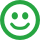
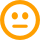

In [71]:
## Web Crawling

from bs4 import BeautifulSoup
import urllib
soup = BeautifulSoup(urllib.request.urlopen('https://www.flipkart.com/puma-slyde-nu-idp-sneakers-men/p/itmf3xxcvu8fwgcp?pid=SHOF32HGW4SNK2DM&lid=LSTSHOF32HGW4SNK2DM6XG3EX&marketplace=FLIPKART&srno=b_1_12&otracker=browse&fm=organic&iid=5285686d-f13b-435f-9276-231e9d39f021.SHOF32HGW4SNK2DM.SEARCH&ppt=Store%20Browse&ppn=Store').read())
print (type(soup))
soup

In [72]:
#Remove Tags and special characters

tags = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def remove_tags(text):
    return tags.sub(' ', text)

# type(soup)

#Fetch the div data in the crawled web page

soup_to_str=str(soup.div)
type(soup_to_str)
soup_to_str

soup_clean=remove_tags(soup_to_str)
soup_clean



"             Explore   Plus                                  Login   Signup          More                    Cart                                                                                                             NOTIFY ME  Get notified when this item comes back in stock.          Home        Footwear        Men's Footwear        Casual Shoes        Puma Casual Shoes          Puma Slyde NU IDP Sneakers For Men (Blue) \n                   Share            Puma\xa0  Slyde NU IDP Sneakers For Men \xa0\xa0(Blue)       ₹1,949  ₹ 2,999   35% off             4.2     12,083 ratings and 1,906 reviews            Sold Out  This item is currently out of stock           This is a genuine product of Puma Sports India Pvt Ltd. The product comes with a standard brand warranty of 90 days. Know More                Color          Black           Black-Cherry Tomato           Blue           Blue Depths-Lapis Blue           Blue Depths-Lapis blue           Golden Brown-Chocolate Brown           M

In [73]:
soup.title

<title>Puma Slyde NU IDP Sneakers For Men - Buy Peacoat-Infinity Color Puma Slyde NU IDP Sneakers For Men Online at Best Price - Shop Online for Footwears in India | Flipkart.com</title>

In [74]:
#Remove punctuations, stopwords and spaces from string

# type(soup_clean)
test99=soup_clean

test99 = remove_punctuations_from_string(test99)
test99 = remove_stopwords_from_string(test99)
test99 = remove_space_from_string(test99)

print(test99)

 explore plus login signup cart notify get notified item comes back stock home footwear men footwear casual shoes puma casual shoes puma slyde nu idp sneakers men blue share puma slyde nu idp sneakers men blue ₹ ₹ ratings reviews sold item currently stock genuine product puma sports india pvt ltd product comes standard brand warranty days know color black black cherry tomato blue blue depths lapis blue blue depths lapis blue golden brown chocolate brown mykonos blue nrgy yellow white olive night peacoat infinity puma black cherry tomato puma black electric blue lemonade quiet shade peacoat tibetan red cherry tomato please select color proceed ✕ size uk india euro euro euro euro euro euro size chart please select size uk india proceed ✕ 💡 tip product runs size larger usually buy uk buy uk read details product details color blue outer material fabric model name slyde nu idp ideal men occasion casual sole material rubber closure lace ups style panel stitch detail loop ankle tip shape roun

In [75]:
#Tokenize and lemmatize the text

test99 = tokenize(test99)
test99 = lemmatize(test99)
test99

['',
 'explore',
 'plus',
 'login',
 'signup',
 'cart',
 'notify',
 'get',
 'notified',
 'item',
 'come',
 'back',
 'stock',
 'home',
 'footwear',
 'men',
 'footwear',
 'casual',
 'shoe',
 'puma',
 'casual',
 'shoe',
 'puma',
 'slyde',
 'nu',
 'idp',
 'sneaker',
 'men',
 'blue',
 'share',
 'puma',
 'slyde',
 'nu',
 'idp',
 'sneaker',
 'men',
 'blue',
 'rating',
 'review',
 'sold',
 'item',
 'currently',
 'stock',
 'genuine',
 'product',
 'puma',
 'sport',
 'india',
 'pvt',
 'ltd',
 'product',
 'come',
 'standard',
 'brand',
 'warranty',
 'day',
 'know',
 'color',
 'black',
 'black',
 'cherry',
 'tomato',
 'blue',
 'blue',
 'depth',
 'lapis',
 'blue',
 'blue',
 'depth',
 'lapis',
 'blue',
 'golden',
 'brown',
 'chocolate',
 'brown',
 'mykonos',
 'blue',
 'nrgy',
 'yellow',
 'white',
 'olive',
 'night',
 'peacoat',
 'infinity',
 'puma',
 'black',
 'cherry',
 'tomato',
 'puma',
 'black',
 'electric',
 'blue',
 'lemonade',
 'quiet',
 'shade',
 'peacoat',
 'tibetan',
 'red',
 'cherry',
 'to

In [76]:
type(test99)

list

In [77]:
fd=nltk.FreqDist(test99)

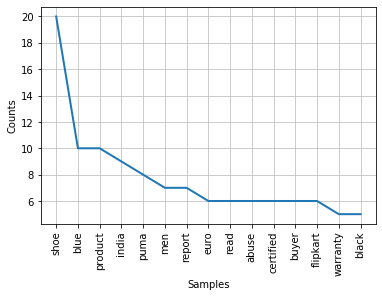

In [78]:
fd.plot(15)